# Projet OLIS : Customers databse clustering

## Cleaning Notebook

In [1]:
%pylab inline 
import pandas as pd
import seaborn as sns
sns.set()
from datetime import date
import dask.dataframe as dd
pd.options.display.max_rows=100
pd.options.display.max_columns=50

Populating the interactive namespace from numpy and matplotlib


In [2]:
#importation des bases de donneés
CLIENTS = pd.read_csv('olist_customers_dataset.csv') #Clients(ID, Adresses) (99441, 5)
PAYMENTS = pd.read_csv('olist_order_payments_dataset.csv') # (order_id, info sur mode de paiement) (103886, 5)
ORDERS = pd.read_csv('olist_orders_dataset.csv') # (order_id, client_id, info sur les étape de traitement de la commande) (99441, 8)
ORDERS_DETAILS = pd.read_csv('olist_order_items_dataset.csv')#(112650, 7) (order_id, order_id, product_id, seller_id, prix, frais livraison, date limite)  
REVIEWS = pd.read_csv('olist_order_reviews_dataset.csv') #(100000, 7) (order_id, score, date, titre, message)
PRODUCTS = pd.read_csv('olist_products_dataset.csv') #(32951, 9) (Produits+catégories+dimensions)
CATEGORIES = pd.read_csv('product_category_name_translation.csv') #(71,2) (traduction des categories en anglais)

### Databases Exploration

#### Orders Database Exploration

In [3]:
ORDERS.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<AxesSubplot:>

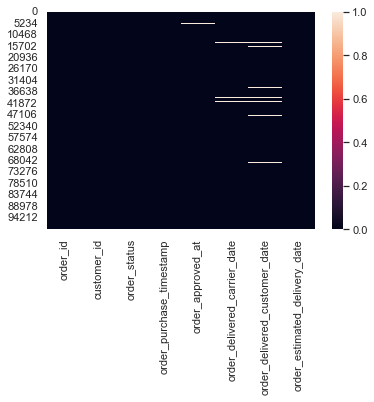

In [4]:
sns.heatmap(ORDERS.isna())
#Well-filled database!

In [5]:
ORDERS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
#Conversion au format année mois
for col in ORDERS.columns[3:]:
    ORDERS[col] = ORDERS[col].map(lambda x: str(x)[:7])
    ORDERS[col] =  pd.to_datetime(ORDERS[col])

In [7]:
ORDERS.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-01,2017-10-01,2017-10-01,2017-10-01,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-01,2018-07-01,2018-07-01,2018-08-01,2018-08-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-01,2018-08-01,2018-08-01,2018-08-01,2018-09-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-01,2017-11-01,2017-11-01,2017-12-01,2017-12-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-01,2018-02-01,2018-02-01,2018-02-01,2018-02-01


In [8]:
ORDERS['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [9]:
ORDERS['year'] = ORDERS['order_purchase_timestamp'].map(lambda x: x.year)
ORDERS['month'] = ORDERS['order_purchase_timestamp'].map(lambda x: x.month)

In [10]:
ORDERS['year'].value_counts()

2018    54011
2017    45101
2016      329
Name: year, dtype: int64

In [11]:
pd.crosstab(ORDERS['month'], ORDERS['year'])

year,2016,2017,2018
month,,,
1,0,800,7269
2,0,1780,6728
3,0,2682,7211
4,0,2404,6939
5,0,3700,6873
6,0,3245,6167
7,0,4026,6292
8,0,4331,6512
9,4,4285,16


In [12]:
### Unique Clients by orders
ORDERS = ORDERS.merge(CLIENTS.iloc[:,0:2])

In [13]:
ORDERS[['customer_unique_id','year']].groupby(by='year').nunique()

,customer_unique_id
year,
2016,326
2017,43713
2018,52749


In [16]:
len(ORDERS.loc[ORDERS['year'].isin([2017,2018]),'customer_unique_id'].unique())

95780

In [17]:
43713+52749

96462

In [15]:
#Only 2017
ORDERS.loc[ORDERS['order_purchase_timestamp'].map(lambda x: x.year)==2017,'order_status'].value_counts()

delivered      43428
shipped          530
unavailable      457
canceled         265
processing       240
invoiced         175
created            4
approved           2
Name: order_status, dtype: int64

In [16]:
#Amount of orders per month
df =  ORDERS.pivot_table(index=ORDERS.order_purchase_timestamp, values='order_id', aggfunc='count')
df

,order_id
order_purchase_timestamp,
2016-09-01,4
2016-10-01,324
2016-12-01,1
2017-01-01,800
2017-02-01,1780
2017-03-01,2682
2017-04-01,2404
2017-05-01,3700
2017-06-01,3245


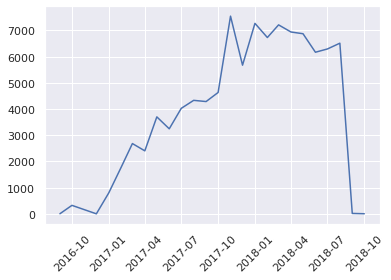

In [17]:
plt.figure()
plt.plot(df.order_id)
plt.xticks(rotation = 45)
plt.show()

In [18]:
df['year'] = df.index.year

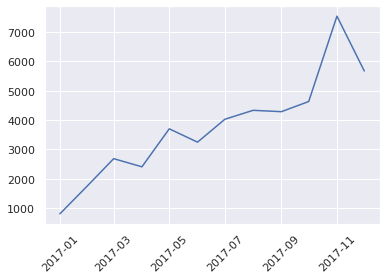

In [19]:
plt.figure()
plt.plot(df.loc[df['year']==2017,'order_id'])
plt.xticks(rotation = 45)
plt.show()

In [20]:
df.index = df.index.strftime('%B')

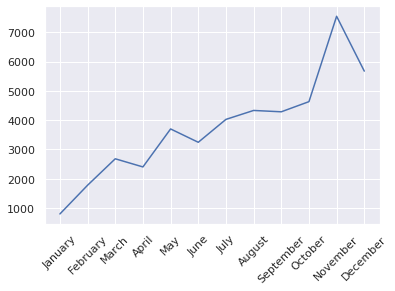

In [21]:
plt.figure()
plt.plot(df.loc[df['year']==2017,'order_id'])
plt.xticks(rotation = 45)
plt.show()

#### Sales Exploration by products categories

In [22]:
ORDERS_DETAILS.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [23]:
PRODUCTS.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [24]:
PRODUCTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [25]:
ORDERS_DETAILS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [26]:
df = ORDERS_DETAILS.iloc[:,[0,2,5,6]].merge(PRODUCTS.iloc[:,[0,1]])
print(df.shape)
df.head()

(112650, 5)


,order_id,product_id,price,freight_value,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,cool_stuff


In [27]:
df['valeur'] = df.price + df.freight_value

In [28]:
order_id_2017 = ORDERS.loc[ORDERS['order_purchase_timestamp'].map(lambda x: x.year)==2017, 'order_id'].unique()

In [29]:
df = df.loc[df['order_id'].isin(order_id_2017),:]

In [30]:
df_prime = df.pivot_table(index='product_category_name', values='valeur', aggfunc='sum', ).sort_values(by='valeur', ascending=False)

In [31]:
df_prime = df_prime.cumsum()*100/df_prime.sum()

In [32]:
df_prime = df_prime.reset_index()

In [33]:
df_prime = df_prime.replace(CATEGORIES['product_category_name'].to_list(), CATEGORIES['product_category_name_english'].to_list())
df_prime.set_index('product_category_name', inplace=True)

In [34]:
len(df_prime)

72

In [35]:
(df_prime<=32).sum()

valeur    4
dtype: int64

In [36]:
(df_prime<=32).sum()*100/73

valeur    5.479452
dtype: float64

In [37]:
cat_80 = df_prime.loc[df_prime['valeur']<=82].index.to_list()
cat_50 = df_prime.loc[df_prime['valeur']<=51].index.to_list()
cat_30 = df_prime.loc[df_prime['valeur']<=32].index.to_list()

In [38]:
cat_50

['bed_bath_table',
 'health_beauty',
 'sports_leisure',
 'watches_gifts',
 'computers_accessories',
 'cool_stuff',
 'furniture_decor']

In [42]:
### How these categories behave throughout the year?

In [43]:
df = df.replace(CATEGORIES['product_category_name'].to_list(), CATEGORIES['product_category_name_english'].to_list())
order_id_cat_80 = df.loc[df['product_category_name'].isin(cat_80),'order_id'].unique()

In [44]:
order_id_cat_80

array(['00010242fe8c5a6d1ba2dd792cb16214',
       '130898c0987d1801452a8ed92a670612',
       '6f8c31653edb8c83e1a739408b5ff750', ...,
       'ffe4b41e99d39f0b837a239110260530',
       'fff7c4452f050315db1b3f24d9df5fcd',
       'fffa82886406ccf10c7b4e35c4ff2788'], dtype=object)

In [45]:
ORDERS_prime = ORDERS.loc[ORDERS['order_id'].isin(order_id_cat_80),:]
df_prime =  ORDERS_prime.pivot_table(index=ORDERS_prime.order_purchase_timestamp, values='order_id', aggfunc='count')
df_prime.index = df_prime.index.strftime('%B')

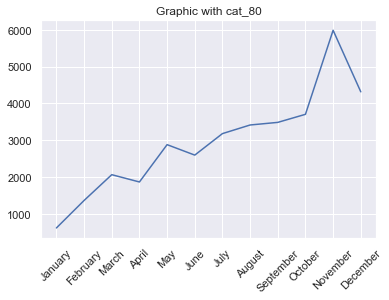

In [46]:
plt.figure()
plt.plot(df_prime)
plt.xticks(rotation = 45)
plt.title('Graphic with cat_80')
plt.show()

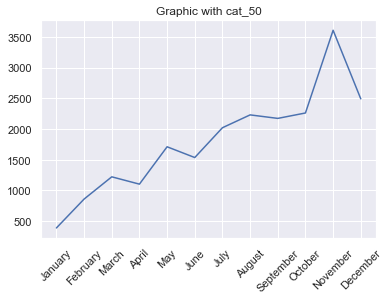

In [47]:
order_id_cat_50 = df.loc[df['product_category_name'].isin(cat_50),'order_id'].unique()
ORDERS_prime = ORDERS.loc[ORDERS['order_id'].isin(order_id_cat_50),:]
df_prime =  ORDERS_prime.pivot_table(index=ORDERS_prime.order_purchase_timestamp, values='order_id', aggfunc='count')
df_prime.index = df_prime.index.strftime('%B')
plt.figure()
plt.plot(df_prime)
plt.xticks(rotation = 45)
plt.title('Graphic with cat_50')
plt.show()

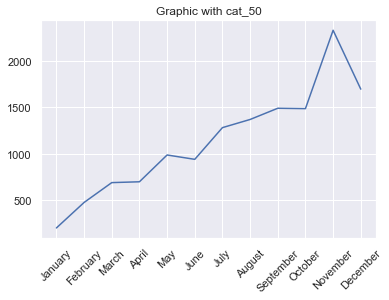

In [48]:
order_id_cat_30 = df.loc[df['product_category_name'].isin(cat_30),'order_id'].unique()
ORDERS_prime = ORDERS.loc[ORDERS['order_id'].isin(order_id_cat_30),:]
df_prime =  ORDERS_prime.pivot_table(index=ORDERS_prime.order_purchase_timestamp, values='order_id', aggfunc='count')
df_prime.index = df_prime.index.strftime('%B')
plt.figure()
plt.plot(df_prime)
plt.xticks(rotation = 45)
plt.title('Graphic with cat_50')
plt.show()

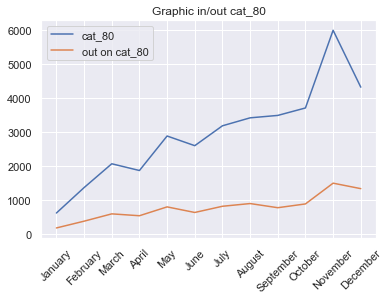

In [49]:
ORDERS_prime = ORDERS.loc[ORDERS['order_id'].isin(order_id_cat_80),:]
df_prime =  ORDERS_prime.pivot_table(index=ORDERS_prime.order_purchase_timestamp, values='order_id', aggfunc='count')
df_prime.index = df_prime.index.strftime('%B')

order_id_out_cat_80 = df.loc[~df['product_category_name'].isin(cat_80),'order_id'].unique()
ORDERS_second = ORDERS.loc[ORDERS['order_id'].isin(order_id_out_cat_80),:]
df_second =  ORDERS_second.pivot_table(index=ORDERS_second.order_purchase_timestamp, values='order_id', aggfunc='count')
df_second.index = df_second.index.strftime('%B')

plt.figure()
plt.plot(df_prime, label='cat_80')
plt.plot(df_second, label = 'out on cat_80')
plt.xticks(rotation = 45)
plt.legend()
plt.title('Graphic in/out cat_80')
plt.show()

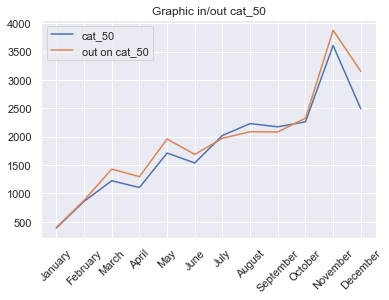

In [50]:
ORDERS_prime = ORDERS.loc[ORDERS['order_id'].isin(order_id_cat_50),:]
df_prime =  ORDERS_prime.pivot_table(index=ORDERS_prime.order_purchase_timestamp, values='order_id', aggfunc='count')
df_prime.index = df_prime.index.strftime('%B')

order_id_out_cat_50 = df.loc[~df['product_category_name'].isin(cat_50),'order_id'].unique()
ORDERS_second = ORDERS.loc[ORDERS['order_id'].isin(order_id_out_cat_50),:]
df_second =  ORDERS_second.pivot_table(index=ORDERS_second.order_purchase_timestamp, values='order_id', aggfunc='count')
df_second.index = df_second.index.strftime('%B')

plt.figure()
plt.plot(df_prime, label='cat_50')
plt.plot(df_second, label = 'out on cat_50')
plt.xticks(rotation = 45)
plt.legend()
plt.title('Graphic in/out cat_50')
plt.show()

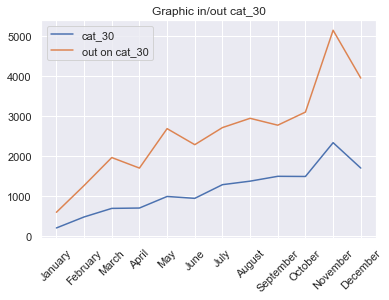

In [51]:
ORDERS_prime = ORDERS.loc[ORDERS['order_id'].isin(order_id_cat_30),:]
df_prime =  ORDERS_prime.pivot_table(index=ORDERS_prime.order_purchase_timestamp, values='order_id', aggfunc='count')
df_prime.index = df_prime.index.strftime('%B')

order_id_out_cat_30 = df.loc[~df['product_category_name'].isin(cat_30),'order_id'].unique()
ORDERS_second = ORDERS.loc[ORDERS['order_id'].isin(order_id_out_cat_30),:]
df_second =  ORDERS_second.pivot_table(index=ORDERS_second.order_purchase_timestamp, values='order_id', aggfunc='count')
df_second.index = df_second.index.strftime('%B')

plt.figure()
plt.plot(df_prime, label='cat_30')
plt.plot(df_second, label = 'out on cat_30')
plt.xticks(rotation = 45)
plt.legend()
plt.title('Graphic in/out cat_30')
plt.show()

#### Notes:
    - All product categories seems having the same sales profile

#### Payments Database Exploration

In [52]:
PAYMENTS.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [53]:
PAYMENTS_2017 = PAYMENTS.loc[PAYMENTS.order_id.isin(order_id_2017),:]

In [54]:
PAYMENTS_2017.info()
# No NA in data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47525 entries, 2 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              47525 non-null  object 
 1   payment_sequential    47525 non-null  int64  
 2   payment_type          47525 non-null  object 
 3   payment_installments  47525 non-null  int64  
 4   payment_value         47525 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.2+ MB


In [55]:
for col in PAYMENTS_2017.columns[1:-1]:
    print(col)
    print(PAYMENTS_2017[col].value_counts())

payment_sequential
1     45095
2      1533
3       310
4       154
5        98
6        72
7        52
8        41
9        34
10       28
11       23
12       15
13       10
15        7
14        7
17        6
18        6
16        6
19        6
21        4
20        4
22        3
26        2
24        2
23        2
25        2
29        1
28        1
27        1
Name: payment_sequential, dtype: int64
payment_type
credit_card    34568
boleto          9508
voucher         3027
debit_card       422
Name: payment_type, dtype: int64
payment_installments
1     23262
2      5362
3      4910
4      3375
10     3038
5      2565
6      1882
8      1720
7       848
9       379
12       75
15       26
24       16
18       16
11       14
20       12
14        9
13        7
21        3
17        3
16        2
22        1
Name: payment_installments, dtype: int64


In [56]:
### Some cross tables

In [57]:
pd.crosstab(PAYMENTS_2017.payment_installments, PAYMENTS_2017.payment_type)
# With all non differated payment method, orders are paid for at once

payment_type,boleto,credit_card,debit_card,voucher
payment_installments,,,,
1,9508,10305,422,3027
2,0,5362,0,0
3,0,4910,0,0
4,0,3375,0,0
5,0,2565,0,0
6,0,1882,0,0
7,0,848,0,0
8,0,1720,0,0
9,0,379,0,0


In [58]:
PAYMENTS_2017 = PAYMENTS_2017.merge(ORDERS[['customer_id','order_id']]).merge(CLIENTS[['customer_unique_id','customer_id']])

In [59]:
PAYMENTS_2017[['order_id','payment_type']][PAYMENTS_2017.payment_type == 'voucher'].groupby('order_id').count().sort_values(by='payment_type', ascending=False)

,payment_type
order_id,
fa65dad1b0e818e3ccc5cb0e39231352,29
ccf804e764ed5650cd8759557269dc13,25
285c2e15bebd4ac83635ccc563dc71f4,21
895ab968e7bb0d5659d16cd74cd1650c,21
ee9ca989fc93ba09a6eddc250ce01742,18
...,...
59de68e3ef040153cc9ea7978eaec149,1
59d34e1064930d037d30041b73683aa7,1
59c134c32edc0046c31ad8bd6f521b61,1


In [60]:
PAYMENTS_2017[PAYMENTS_2017.order_id=='fa65dad1b0e818e3ccc5cb0e39231352']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,customer_unique_id
2696,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2697,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2698,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2699,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2700,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2701,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2702,fa65dad1b0e818e3ccc5cb0e39231352,25,voucher,1,3.68,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2703,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2704,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a
2705,fa65dad1b0e818e3ccc5cb0e39231352,11,voucher,1,4.03,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a


In [63]:
PAYMENTS_2017[PAYMENTS_2017.customer_unique_id=='f9ae226291893fda10af7965268fb7f6']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,customer_unique_id
605,370e2e6c1a9fd451eb7f0852daa3b006,7,voucher,1,6.82,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
606,370e2e6c1a9fd451eb7f0852daa3b006,11,voucher,1,6.49,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
607,370e2e6c1a9fd451eb7f0852daa3b006,1,credit_card,1,38.58,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
608,370e2e6c1a9fd451eb7f0852daa3b006,5,voucher,1,3.41,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
609,370e2e6c1a9fd451eb7f0852daa3b006,10,voucher,1,13.79,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
610,370e2e6c1a9fd451eb7f0852daa3b006,3,voucher,1,5.71,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
611,370e2e6c1a9fd451eb7f0852daa3b006,8,voucher,1,3.78,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
612,370e2e6c1a9fd451eb7f0852daa3b006,6,voucher,1,2.16,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
613,370e2e6c1a9fd451eb7f0852daa3b006,9,voucher,1,6.88,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6
614,370e2e6c1a9fd451eb7f0852daa3b006,2,voucher,1,3.72,55f7adf99fd2a2c01af34e2dfa272c9f,f9ae226291893fda10af7965268fb7f6


#### Notes : payment_sequential feature causes instances duplicating. Ex: Although I had bought an article in one installment, if I had used a credit card for times (sequentiel will be at 4), I'll get 4 times the concerned order repeated in database with a different payment value

In [120]:
# is all orders have unique payment mode each one? 

for i in PAYMENTS['payment_installments'].unique():
    print(i)
    print(PAYMENTS.loc[PAYMENTS['payment_installments']==i,['order_id','payment_type']].shape) ,
    print(PAYMENTS.loc[PAYMENTS['payment_installments']==i,['order_id','payment_type']].drop_duplicates().shape)
    X = PAYMENTS.loc[PAYMENTS['payment_installments']==i,['order_id','payment_type']].drop_duplicates()
    print(len(X['order_id'].unique()))
    print()

#No For 1-installment payment, there are some people whose combine payment method
#Let's deep in

8
(4268, 2)
(4253, 2)
4253

1
(52546, 2)
(50588, 2)
49060

2
(12413, 2)
(12389, 2)
12389

3
(10461, 2)
(10443, 2)
10443

6
(3920, 2)
(3916, 2)
3916

5
(5239, 2)
(5234, 2)
5234

4
(7098, 2)
(7088, 2)
7088

10
(5328, 2)
(5315, 2)
5315

7
(1626, 2)
(1623, 2)
1623

12
(133, 2)
(133, 2)
133

9
(644, 2)
(644, 2)
644

13
(16, 2)
(16, 2)
16

15
(74, 2)
(74, 2)
74

24
(18, 2)
(18, 2)
18

11
(23, 2)
(23, 2)
23

18
(27, 2)
(27, 2)
27

14
(15, 2)
(15, 2)
15

20
(17, 2)
(17, 2)
17

21
(3, 2)
(3, 2)
3

17
(8, 2)
(8, 2)
8

22
(1, 2)
(1, 2)
1

0
(2, 2)
(2, 2)
2

16
(5, 2)
(5, 2)
5

23
(1, 2)
(1, 2)
1



In [128]:
## Who are these orders?
i = 1
X = PAYMENTS.loc[PAYMENTS['payment_installments']==i,['order_id','payment_type']].drop_duplicates()
cle_count = X['order_id'].value_counts()>1
cle = cle_count.index[cle_count==True]

In [137]:
# lest's pick up one of them
PAYMENTS[PAYMENTS.order_id==cle[0]]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
28633,cda286fbc87f2e1358e2804b1d77ca0f,1,credit_card,1,5.45
31319,cda286fbc87f2e1358e2804b1d77ca0f,2,voucher,1,131.62


In [76]:
(pd.crosstab(PAYMENTS_2017.payment_installments, PAYMENTS_2017.payment_type)['credit_card']*100 / 34568).sort_values(ascending=False)
# 70% of credit card payments are made in installments
# Somes preferences seems to emerge payments in 2 times, 3, 4, 10, 5 (around 56% of credit card payment)

payment_installments
1     29.810808
2     15.511456
3     14.203888
4      9.763365
10     8.788475
5      7.420157
6      5.444342
8      4.975700
7      2.453136
9      1.096390
12     0.216964
15     0.075214
18     0.046286
24     0.046286
11     0.040500
20     0.034714
14     0.026036
13     0.020250
17     0.008679
21     0.008679
16     0.005786
22     0.002893
Name: credit_card, dtype: float64

In [77]:
(PAYMENTS_2017.pivot_table(index='payment_type', values ='payment_value', aggfunc='sum', margins=True)*100/7249746.73).sort_values(by='payment_value', ascending=False)

,payment_value
payment_type,
All,100.000000
credit_card,77.759598
boleto,19.256719
voucher,2.386055
debit_card,0.597627


In [ ]:
PAYMENTS_2017['payment_value'].describe()

count    47525.000000
mean       152.545960
std        222.815426
min          0.000000
25%         55.680000
50%         97.770000
75%        168.460000
max      13664.080000
Name: payment_value, dtype: float64

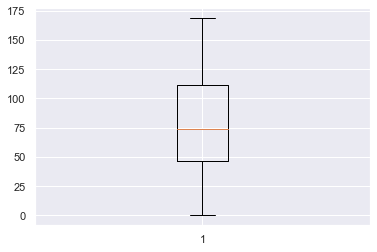

In [ ]:
plt.figure()
plt.boxplot(PAYMENTS_2017['payment_value'][PAYMENTS_2017['payment_value']<=169])
plt.show()

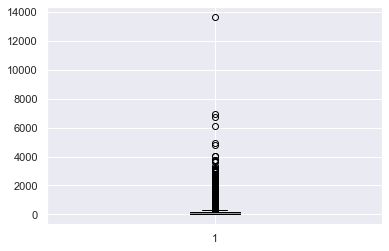

In [ ]:
plt.figure()
plt.boxplot(PAYMENTS_2017['payment_value'])
plt.show()
#Too big outliers are present

In [ ]:
#How many are there payment values overs 169? 
(PAYMENTS_2017['payment_value']>=169).sum()
# 24% or 11850

#### Reviews Database Exploration

In [ ]:
REVIEWS.head()

In [ ]:
REVIEWS_2017 = REVIEWS.loc[REVIEWS['order_id'].isin(order_id_2017),:]
REVIEWS_2017_cat_80 = REVIEWS.loc[REVIEWS['order_id'].isin(order_id_cat_80),:]

In [ ]:
print(REVIEWS_2017['review_score'].astype('object').describe(), '\n')
print(REVIEWS_2017['review_score'].value_counts(normalize=True).sort_values(ascending=False)*100)

In [ ]:
print(REVIEWS_2017_cat_80['review_score'].astype('object').describe(), '\n')
print(REVIEWS_2017_cat_80['review_score'].value_counts(normalize=True).sort_values(ascending=False)*100)

In [ ]:
# Globally, we have around 15% of orders which got a bad score: 1 or 2

#### ORDERS_DETAILS Database Exploration

In [64]:
ORDERS_DETAILS['product_global_price'] = ORDERS_DETAILS.price + ORDERS_DETAILS.freight_value   
ORDERS_DETAILS['prct_fret_on_global_price'] = ORDERS_DETAILS.freight_value*100 / ORDERS_DETAILS['product_global_price']
#Joining Category for each product

In [65]:
ORDERS_DETAILS['prct_fret_on_global_price'].describe()

count    112650.000000
mean         21.336434
std          12.949813
min           0.000000
25%          11.819196
50%          18.788733
75%          28.214357
max          96.328294
Name: prct_fret_on_global_price, dtype: float64

### Working Database Building

Clients, nb commande sur l'annee, nombre de mois différent ou une commande a été passé, date derniere commande, valeur dernière,delai de livraison(min, max, moyen, sd),valeur panier(min, max, moyen, sd), nombre d'articles par commande(min, max, moyen, sd), nbre de fois echelonnemant( 1, 2 4 3 5 10), Nombre de paiement comptant, localisation client, nombre de commande en paiement seq (1, 2 ,>=3), Nombre de commande avec avis, Nombre de fois avec une avis 5,4 / 3 / 2,1, , nombre de commande remnoursés, nombre de commande complete, durée entre 2 commandes(min, max, moyen, sd), nombre de catégorie par commande( min, max, moyen, sd)

In [7]:
def orders_processing(yyyy, ref_for_recence):
    '''
    This function creates theses following target variables by customer: 
        -Number of orders for a periode
        -Numbers of distinct month where any order was passed
        -Last order date
        -Delivering delay(min, max, mean, std)
        -time between 2 orders(min, max, mean, std)
        
    *** INPUT
        yyyy : reference year
        ref_for_recence : date(yyyy-mm-dd) used to find most recent order
    '''
    # Loading orders database
    ORDERS = pd.read_csv('olist_orders_dataset.csv')
    #filtering on right period
    ORDERS_yyyy = ORDERS[pd.to_datetime(ORDERS['order_purchase_timestamp']).map(lambda x: x.year)==yyyy]
    #deleting useless columns
    ORDERS_yyyy = ORDERS_yyyy.iloc[:,[0,1,3,7]]
    #Joining customer_unique_id
    CLIENTS = pd.read_csv('olist_customers_dataset.csv')
    ORDERS_yyyy = ORDERS_yyyy.merge(CLIENTS, on='customer_id', how='left')
    #Delivering delay
    ORDERS_yyyy['delay'] = (pd.to_datetime(ORDERS_yyyy['order_estimated_delivery_date']) - pd.to_datetime(ORDERS_yyyy['order_purchase_timestamp'])).map(lambda x: x.days)
    #Order Month
    ORDERS_yyyy['order_month'] = pd.to_datetime(ORDERS_yyyy['order_purchase_timestamp']).map(lambda x: x.strftime('%B'))
    #Number of days after last order
    ORDERS_yyyy['recence'] = (pd.to_datetime(ref_for_recence) - pd.to_datetime(ORDERS_yyyy['order_purchase_timestamp'])).map(lambda x: x.days)
    
    #Sorting database
    ORDERS_yyyy.loc[:,'order_purchase_timestamp'] = pd.to_datetime(ORDERS_yyyy['order_purchase_timestamp'])
    ORDERS_yyyy = ORDERS_yyyy.sort_values(by=['customer_unique_id','order_purchase_timestamp'])
    
    #Days between 2 orders
    ORDERS_yyyy = ORDERS_yyyy.set_index('customer_unique_id')
    ORDERS_yyyy['duree'] = ORDERS_yyyy.pivot_table(index=ORDERS_yyyy.index, values='order_purchase_timestamp', dropna=False, aggfunc='diff')
    ORDERS_yyyy = ORDERS_yyyy.reset_index()
    ORDERS_yyyy['duree'] = ORDERS_yyyy['duree'].map(lambda x: x.days)
    
    #target Variales creation
    valeurs = ['order_id','recence', 'order_month', 'delay', 'duree']
    functions = {'order_id':'count', 'recence': 'min', 'order_month':lambda x: len(x.unique()), 'delay':['min','max', 'mean', 'std'], 'duree':['min','max', 'mean', 'std']}
    df_target = ORDERS_yyyy.pivot_table(index='customer_unique_id', values=valeurs, aggfunc=functions).fillna(0)
    
    return df_target

In [8]:
### REVIEWS

In [9]:
def reviews_processing(yyyy):
    '''
    This function creates theses following target variables by customer: 
        -Number of orders with a score reviews of 5/4 or 1/2
        
    *** INPUT
        yyyy : reference year
        ref_for_recence : date(yyyy-mm-dd) used to find most recent order
    '''
    # Loading orders database
    REVIEWS = pd.read_csv('olist_order_reviews_dataset.csv')
    #deleting useless columns
    REVIEWS = REVIEWS.iloc[:,[1,2,5]]
    #Set date dtype for review_creation_date variable
    REVIEWS.review_creation_date = pd.to_datetime(REVIEWS.review_creation_date)
    #Keeping last reviews for each orders
    REVIEWS = REVIEWS.loc[REVIEWS.groupby('order_id').review_creation_date.idxmax()]
    #Keeping orders for the right period (yyyy)
    ORDERS_KEYS = pd.read_csv('olist_orders_dataset.csv')
    ORDERS_KEYS = ORDERS_KEYS.loc[pd.to_datetime(ORDERS_KEYS['order_purchase_timestamp']).map(lambda x: x.year)==yyyy, ['order_id','customer_id']]
    #Joining customer_unique_id
    CLIENTS = pd.read_csv('olist_customers_dataset.csv')
    ORDERS_KEYS = ORDERS_KEYS.merge(CLIENTS.iloc[:,[0,1]], on='customer_id', how='left')
    REVIEWS = ORDERS_KEYS.merge(REVIEWS,how='left')
    
    #target Variales creation
    df_target = REVIEWS.pivot_table(index = 'customer_unique_id', values='order_id', columns='review_score', aggfunc='count')
    df_target = df_target.fillna(0)
    df_target['note_4_ou_5'] = df_target[4] + df_target[5]
    df_target['note_1_ou_2'] = df_target[1] + df_target[2]
    df_target.drop(range(1,6), axis=1, inplace=True)
    
    return df_target

In [10]:
#Payments

In [11]:
def payments_processing(yyyy):
    '''
    This function creates theses following target variables by customer: 
        -Number of orders using installments (1,2,3,4,5,10)
        -Numbers of orders sold using credit card
        
    *** INPUT
        yyyy : reference year
    '''
    # Loading orders database
    PAYMENTS = pd.read_csv('olist_order_payments_dataset.csv')
    #deleting useless columns
    PAYMENTS.drop(['payment_sequential', 'payment_value'], axis=1, inplace=True)
    #Reducing payment installments categories
    PAYMENTS['payment_installments'] = np.where(PAYMENTS['payment_installments'].isin([1,2,3,4,5,10]), PAYMENTS['payment_installments'], '999')
    #Reducing payment type categories
    PAYMENTS['payment_type'] = np.where(PAYMENTS['payment_type']=='credit_card', PAYMENTS['payment_type'], 'paiement comptant')

    #Keeping orders for the right period (yyyy)
    ORDERS_KEYS = pd.read_csv('olist_orders_dataset.csv')
    ORDERS_KEYS = ORDERS_KEYS.loc[pd.to_datetime(ORDERS_KEYS['order_purchase_timestamp']).map(lambda x: x.year)==yyyy, ['order_id','customer_id']]
    #Joining customer_unique_id
    CLIENTS = pd.read_csv('olist_customers_dataset.csv')
    ORDERS_KEYS = ORDERS_KEYS.merge(CLIENTS.iloc[:,[0,1]], on='customer_id', how='left')
    PAYMENTS = ORDERS_KEYS.merge(PAYMENTS, how='left')
    PAYMENTS = pd.get_dummies(PAYMENTS,columns=['payment_installments', 'payment_type'], drop_first=False, prefix='', prefix_sep='')
    
    #target Variales creation
    df_target = PAYMENTS = PAYMENTS.pivot_table(index='customer_unique_id', values=['1','2','3','4','5','10','credit_card'], aggfunc='sum')
   
    return df_target

In [12]:
#Orders details

In [13]:
def odrers_details_processing(yyyy):
    '''
    This function creates theses following target variables by customer: 
        - Last order value
        - Order value (min, max, mean, std)
        - Nb of product by order ( min, max, mean, std)
        - Nb categories by order ( min, max, mean, std)
        
    *** INPUT
        yyyy : reference year
    '''
  
    # Loading orders database
    ORDERS_DETAILS = pd.read_csv('olist_order_items_dataset.csv')
    #Global product price
    ORDERS_DETAILS['product_global_price'] = ORDERS_DETAILS.price + ORDERS_DETAILS.freight_value   
    
    #Joining Category for each product
    CATEGORIES = pd.read_csv('product_category_name_translation.csv')
    PRODUCTS = pd.read_csv('olist_products_dataset.csv')
    ORDERS_DETAILS = ORDERS_DETAILS.iloc[:,[0,2,7]].merge(PRODUCTS.iloc[:,[0,1]], how='left').replace(CATEGORIES.product_category_name.to_list(), CATEGORIES.product_category_name_english.to_list())

    #Keeping orders for the right period (yyyy)
    ORDERS_KEYS = pd.read_csv('olist_orders_dataset.csv')
    ORDERS_KEYS = ORDERS_KEYS.loc[pd.to_datetime(ORDERS_KEYS['order_purchase_timestamp']).map(lambda x: x.year)==yyyy, ['order_id','customer_id','order_purchase_timestamp']]
    ORDERS_KEYS['order_purchase_timestamp'] = pd.to_datetime(ORDERS_KEYS['order_purchase_timestamp'])
    
    #Joining customer_unique_id
    CLIENTS = pd.read_csv('olist_customers_dataset.csv')
    ORDERS_KEYS = ORDERS_KEYS.merge(CLIENTS.iloc[:,[0,1]], on='customer_id', how='left')
    
    #Joining orders_details
    ORDERS_DETAILS = ORDERS_KEYS.merge(ORDERS_DETAILS, how='left')

    #target Variales creation
    ## ORDER values
    LAST_ORDERS_AMOUNT = ORDERS_DETAILS.loc[ORDERS_DETAILS.groupby('customer_unique_id').order_purchase_timestamp.idxmax(), ['customer_unique_id','order_id','product_global_price']]
    LAST_ORDERS_AMOUNT = LAST_ORDERS_AMOUNT.pivot_table(index='customer_unique_id', values='product_global_price', aggfunc='sum').rename(columns = {'product_global_price':'last_order_value'})
    
    ## For each order: 
    ### global value, 
    ORDERS_DETAILS = ORDERS_DETAILS.drop('product_global_price', axis=1).merge(ORDERS_DETAILS.pivot_table(index = 'order_id', values = 'product_global_price', aggfunc='sum'), left_on='order_id', right_index=True)
    ### numbers of products
    ORDERS_DETAILS = ORDERS_DETAILS.merge(ORDERS_DETAILS.order_id.value_counts().rename('Product count'), how = 'left', right_index=True, left_on='order_id')
    ### number of disctinct categories
    ORDERS_DETAILS = ORDERS_DETAILS.drop('product_category_name', axis=1).merge(ORDERS_DETAILS.pivot_table(index='order_id', values = 'product_category_name', aggfunc = lambda x: len(x.unique())), left_on='order_id', right_index=True)
    
    valeurs = ['product_global_price', 'product_category_name', 'Product count']
    
    fonctions = {'product_global_price':['min','max','mean','std'], 
             'product_category_name':['min','max','mean','std'],
            'Product count':['min','max','mean','std']}

    df_target = ORDERS_DETAILS.pivot_table(index='customer_unique_id', values=valeurs, aggfunc=fonctions).fillna('0')
    df_target = df_target.merge(LAST_ORDERS_AMOUNT, right_index=True, left_index=True)
   
    return df_target

In [15]:
def db_generator(yyyy, ref_for_recence) :
    '''
    This functions merge all small databases provided by thematic processing functions.
    
    *** INPUT
    yyyy : reference year
    ref_for_recence : date(yyyy-mm-dd) used to find most recent order
    '''
    
    #Adding orders processed databasde
    db = orders_processing(yyyy, ref_for_recence)
    
    #Adding orders details processed databse
    db = db.merge(odrers_details_processing(yyyy), right_index=True, left_index=True)
    
    #Adding orders details processed databse
    db = db.merge(payments_processing(yyyy), right_index=True, left_index=True)
    
    #Adding orders details processed databse
    db = db.merge(reviews_processing(yyyy), right_index=True, left_index=True)
    
    return db

In [16]:
df = db_generator(2017, '2018-01-01')

D:\Anaconda\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


In [17]:
df.head()

,"(delay, max)","(delay, mean)","(delay, min)","(delay, std)","(duree, max)","(duree, mean)","(duree, min)","(duree, std)","(order_id, count)","(order_month, <lambda>)","(recence, min)","(Product count, max)","(Product count, mean)","(Product count, min)","(Product count, std)","(product_category_name, max)","(product_category_name, mean)","(product_category_name, min)","(product_category_name, std)","(product_global_price, max)","(product_global_price, mean)","(product_global_price, min)","(product_global_price, std)",last_order_value,1,10,2,3,4,5,credit_card,note_4_ou_5,note_1_ou_2
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,27.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0,1,1,296,1.0,1.0,1.0,0,1.0,1.0,1.0,0,86.22,86.22,86.22,0,86.22,0,0,0,0,0,0,1,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,1,1,80,1.0,1.0,1.0,0,1.0,1.0,1.0,0,43.62,43.62,43.62,0,43.62,0,0,0,0,1,0,1,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,1,1,47,1.0,1.0,1.0,0,1.0,1.0,1.0,0,196.89,196.89,196.89,0,196.89,0,0,0,0,0,0,1,1.0,0.0
0005e1862207bf6ccc02e4228effd9a0,32.0,32.0,32.0,0.0,0.0,0.0,0.0,0.0,1,1,302,1.0,1.0,1.0,0,1.0,1.0,1.0,0,150.12,150.12,150.12,0,150.12,0,0,0,1,0,0,1,1.0,0.0
0006fdc98a402fceb4eb0ee528f6a8d4,27.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0,1,1,166,1.0,1.0,1.0,0,1.0,1.0,1.0,0,29.00,29.00,29.00,0,29.00,0,0,1,0,0,0,1,0.0,0.0


In [18]:
(df.isna()).sum()

(delay, max)                     0
(delay, mean)                    0
(delay, min)                     0
(delay, std)                     0
(duree, max)                     0
(duree, mean)                    0
(duree, min)                     0
(duree, std)                     0
(order_id, count)                0
(order_month, <lambda>)          0
(recence, min)                   0
(Product count, max)             0
(Product count, mean)            0
(Product count, min)             0
(Product count, std)             0
(product_category_name, max)     0
(product_category_name, mean)    0
(product_category_name, min)     0
(product_category_name, std)     0
(product_global_price, max)      0
(product_global_price, mean)     0
(product_global_price, min)      0
(product_global_price, std)      0
last_order_value                 0
1                                0
10                               0
2                                0
3                                0
4                   

In [19]:
df.shape

(43713, 33)

In [21]:
df_xopy = df.copy()

In [ ]:
df = df_xopy

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df.loc[:,:] = sc.fit_transform(df)

In [23]:
df

,"(delay, max)","(delay, mean)","(delay, min)","(delay, std)","(duree, max)","(duree, mean)","(duree, min)","(duree, std)","(order_id, count)","(order_month, <lambda>)","(recence, min)","(Product count, max)","(Product count, mean)","(Product count, min)","(Product count, std)","(product_category_name, max)","(product_category_name, mean)","(product_category_name, min)","(product_category_name, std)","(product_global_price, max)","(product_global_price, mean)","(product_global_price, min)","(product_global_price, std)",last_order_value,1,10,2,3,4,5,credit_card,note_4_ou_5,note_1_ou_2
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,0.330033,0.344699,0.355973,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,1.659004,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,-0.324480,-0.321413,-0.315823,-0.080993,-0.292171,-0.715136,-0.267128,-0.367414,-0.348979,-0.284542,-0.246626,0.440453,-1.697518,-0.418332
0000f6ccb0745a6a4b88665a16c9f078,0.842082,0.862592,0.874440,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,-0.598544,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,-0.511208,-0.509635,-0.504709,-0.080993,-0.504563,-0.715136,-0.267128,-0.367414,-0.348979,3.400850,-0.246626,0.440453,0.450882,-0.418332
0004aac84e0df4da2b147fca70cf8255,-0.566053,-0.561614,-0.551345,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,-0.943447,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,0.160620,0.167567,0.174882,-0.080993,0.259600,-0.715136,-0.267128,-0.367414,-0.348979,-0.284542,-0.246626,0.440453,0.450882,-0.418332
0005e1862207bf6ccc02e4228effd9a0,0.970094,0.992066,1.004057,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,1.721714,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,-0.044387,-0.039080,-0.032494,-0.080993,0.026417,-0.715136,-0.267128,-0.367414,2.757930,-0.284542,-0.246626,0.440453,0.450882,-0.418332
0006fdc98a402fceb4eb0ee528f6a8d4,0.330033,0.344699,0.355973,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,0.300295,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,-0.575292,-0.574231,-0.569533,-0.080993,-0.577454,-0.715136,-0.267128,2.627879,-0.348979,-0.284542,-0.246626,0.440453,-1.697518,-0.418332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.970094,0.992066,1.004057,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,-1.392866,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,0.031006,0.036916,0.043770,-0.080993,0.112172,-0.715136,-0.267128,2.627879,-0.348979,-0.284542,-0.246626,0.440453,0.450882,-0.418332
fffcf5a5ff07b0908bd4e2dbc735a684,3.786365,3.840478,3.855628,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,0.718359,1.596169,1.624200,1.670146,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,8.359709,8.432231,8.468715,-0.080993,5.002972,-0.715136,3.576513,-0.367414,-0.348979,-0.284542,-0.246626,0.440453,0.450882,-0.418332
fffea47cd6d3cc0a88bd621562a9d061,0.970094,0.992066,1.004057,-0.106181,-0.094242,-0.092708,-0.090059,-0.03116,-0.159706,-0.111868,-1.215189,-0.264056,-0.262989,-0.257078,-0.068369,-0.08752,-0.087056,-0.082013,-0.030767,-0.331668,-0.328659,-0.323094,-0.080993,-0.300347,0.628718,-0.267128,-0.367414,-0.348979,-0.284542,-0.246626,0.440453,0.450882,-0.418332
